In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
from scipy.spatial.distance import pdist, cdist
%pylab inline

from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(20, 10)

In [3]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_df = df_tcams_nd.copy()
full_df.rename(columns={'pXC50_3D7' : 'POTENCY'}, inplace=True)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV

model_dict = {'ridge' : {'m': Ridge, 'kw': {'fit_intercept': True, 'alpha': 0.1}},
              'rcv':  {'m': RidgeCV, 'kw': {'cv': 5}},
              'rf': {'m': RandomForestRegressor, 'kw': {'n_estimators': 100, 'n_jobs': 4, 'max_depth': 10}}}

method = 'rf'
mdl = model_dict[method]['m'](**model_dict[method]['kw'])

In [5]:
full_df.dropna(subset=['POTENCY'], inplace=True)
fpa = np.asarray([x for x in full_df.fps.values])

### Bias correction
The main thing we do here is the bias correction...  Let's draw the plot first...

In [6]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0]
i = 0

redo = False

if redo:
    all_dists = np.asarray([])

    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        all_dists = np.concatenate((blk_dists, all_dists))
        i += 10000
        pass
    np.save('all_dists.npy', all_dists)
else:
    all_dists = np.load('all_dists.npy')

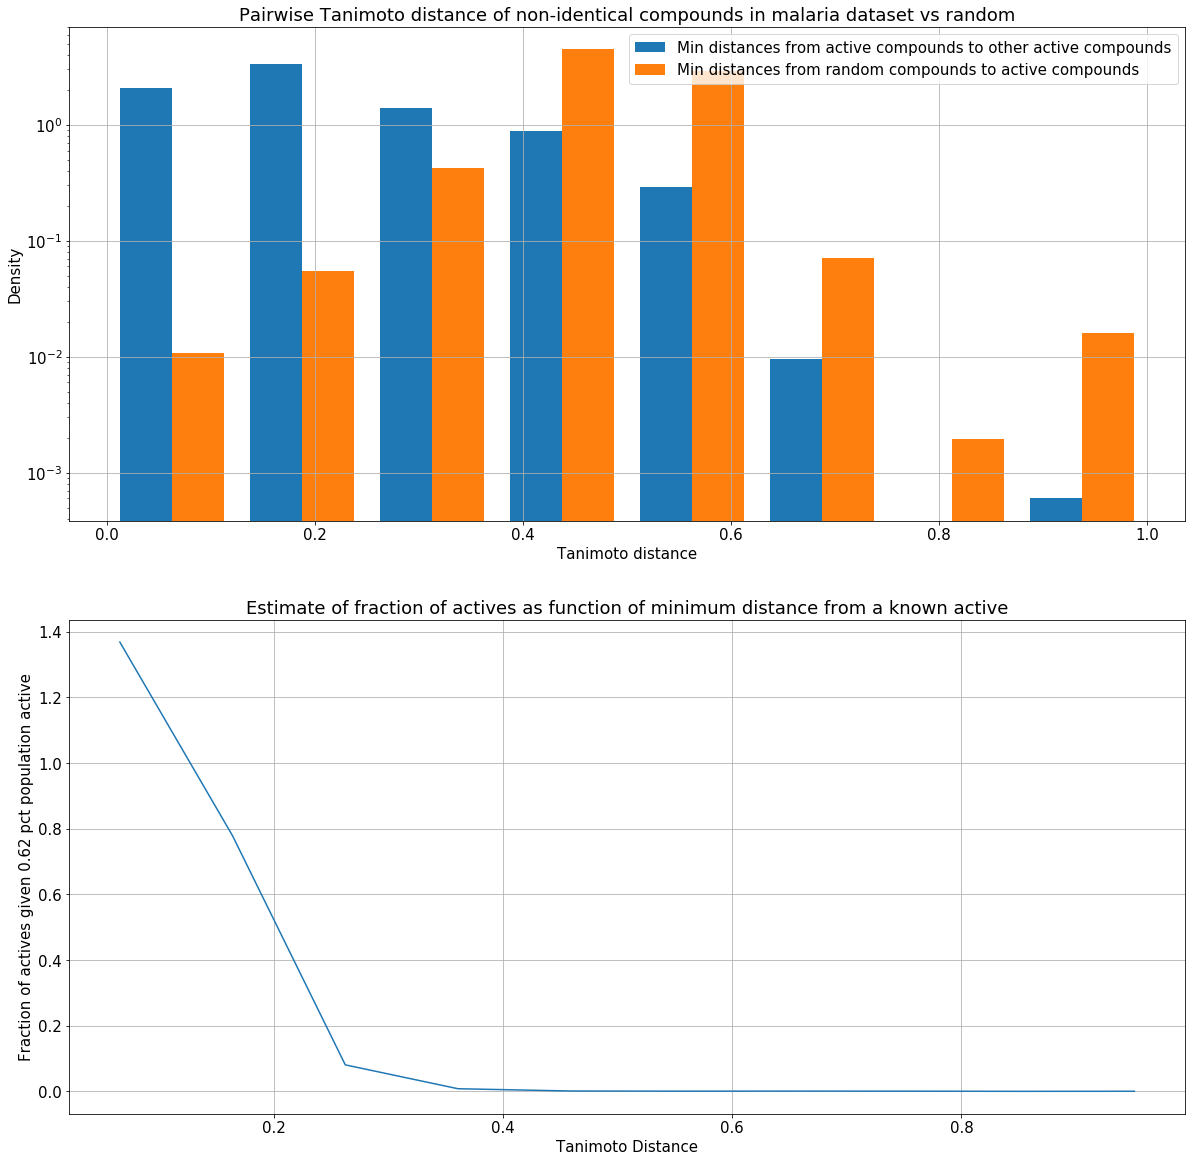

In [7]:
num_inactive_per_active = 2.2e6/13533

np.random.seed(42)

cdfpa = cdist(fpa, fpa, metric='jaccard')
cdfpa[cdfpa==0] = np.nan
mtc_dists = nanmin(cdfpa, axis=1)
cdfpa = None

mal_hist= np.histogram(mtc_dists[~np.isnan(mtc_dists)], density=True, bins=10)
mra_hist = np.histogram(all_dists[~np.isnan(all_dists)], density=True, bins=10)
x_axis = 0.5*(mal_hist[1][1:] + mal_hist[1][:-1])
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
plt.hist((mtc_dists[~np.isnan(mtc_dists)],all_dists[~np.isnan(all_dists)]), 
         bins=8, density=True, label=('Min distances from active compounds to other active compounds', 
                                       'Min distances from random compounds to active compounds'))
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
plt.grid('True')
plt.legend(loc='best')
plt.title('Pairwise Tanimoto distance of non-identical compounds in malaria dataset vs random')
plt.subplot(212)
plt.plot(x_axis, mal_hist[0]/(num_inactive_per_active*mra_hist[0]))
plt.grid(True)
plt.xlabel('Tanimoto Distance')
plt.ylabel('Fraction of actives given %.2f pct population active' % (100/num_inactive_per_active))
_ = plt.title('Estimate of fraction of actives as function of minimum distance from a known active')
savefig('figures/fig5_bias_correction.png')

In [8]:
x = np.arange(-4, 4.5, 0.5) 
y = 0.5 / np.sqrt(2 * np.pi) * np.exp(-x ** 2 / 2.)

In [9]:
np.sum(y)

0.99998241548955635

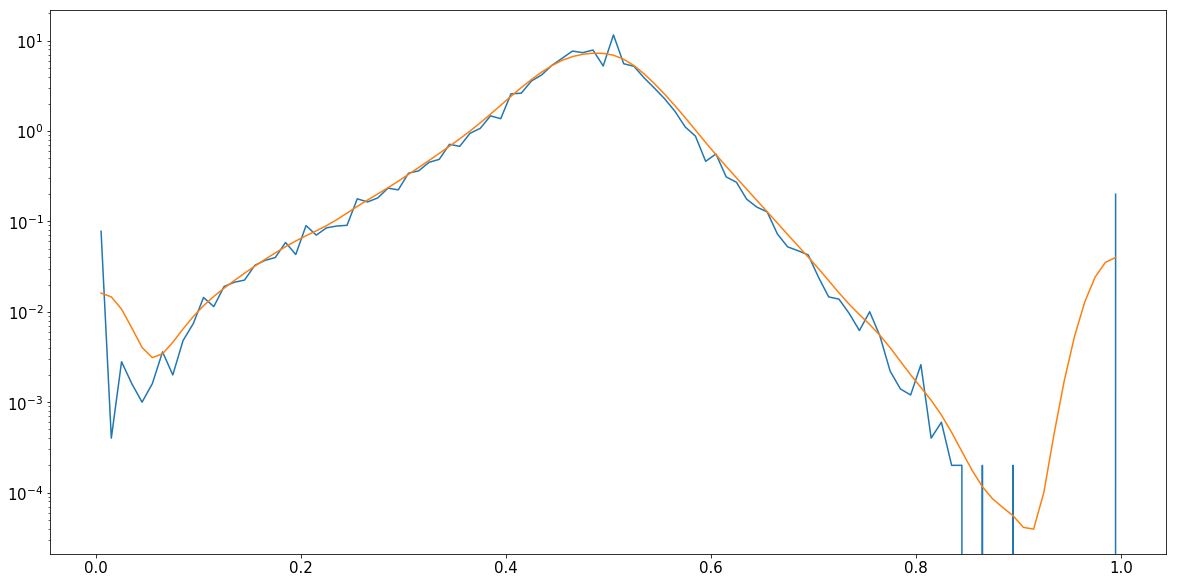

In [10]:
mra_hist = np.histogram(all_dists[~np.isnan(all_dists)], density=True, bins=100)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(x_axis, np.convolve(mra_hist[0], y, mode='same'))
_ = plt.yscale('log')

Ok, so now we're going to make the same plot as the one above, but we're going to sample with replacement from the active distribution, so as we get error bars on the plot above.  We'll assume the numerator ( the orange bars) has zero error (as it is calculated from 500K points).

In [11]:
full_df.shape[0]/2

6663.5

In [12]:
mal_hist_hdr = []
num2choose = int(full_df.shape[0]/2)
for i in range(40):
    print('Doing ',i)
    idcs = np.random.choice(full_df.shape[0], num2choose, replace=False)
    cd = cdist(fpa[idcs], fpa[idcs], metric='jaccard')
    cd[np.eye(num2choose) == 1] = 2
    mtcs_dists = nanmin(cd, axis=1)
    mals_hist= np.histogram(mtcs_dists[~np.isnan(mtcs_dists)], density=True, bins=10)
    mal_hist_hdr.append(mals_hist)

Doing  0
Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
Doing  15
Doing  16
Doing  17
Doing  18
Doing  19
Doing  20
Doing  21
Doing  22
Doing  23
Doing  24
Doing  25
Doing  26
Doing  27
Doing  28
Doing  29
Doing  30
Doing  31
Doing  32
Doing  33
Doing  34
Doing  35
Doing  36
Doing  37
Doing  38
Doing  39


In [75]:
mh_y_mean = np.mean(np.vstack((ml[0] for ml in mal_hist_hdr)), axis=0)

In [76]:
mh_y_err = np.std(np.vstack((ml[0] for ml in mal_hist_hdr)), axis=0)

In [77]:
mh_yx_mean = np.mean(np.vstack((ml[1] for ml in mal_hist_hdr)), axis=0)
mh_x_mean = 0.5 * (mh_yx_mean[:-1] + mh_yx_mean[1:])

In [78]:
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
sm_rta = partial(np.interp, xp=x_axis, fp=np.convolve(mra_hist[0], y, mode='same'))                              

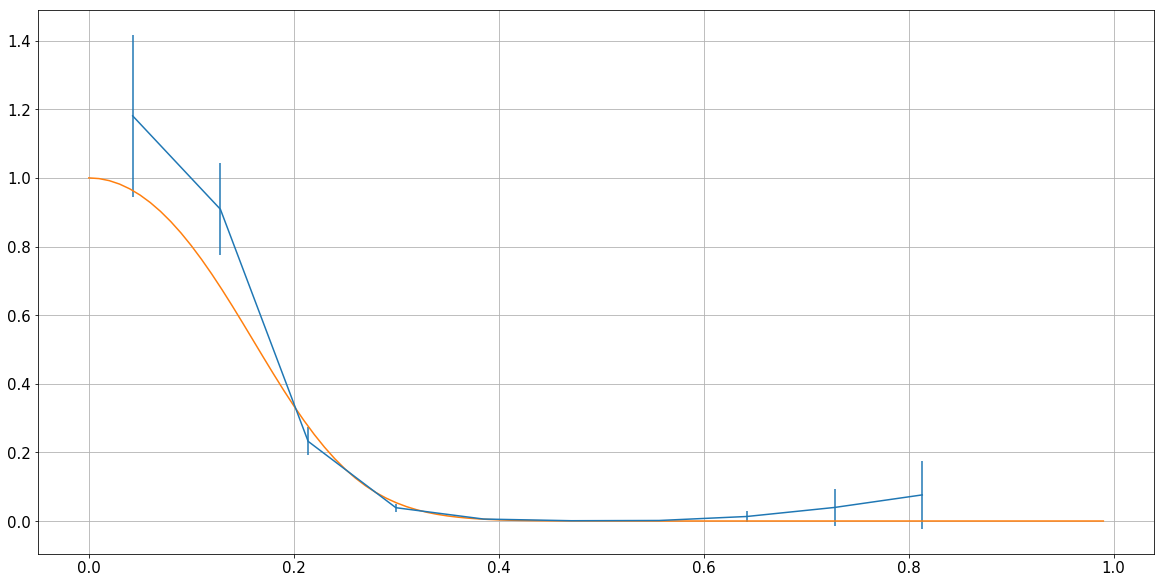

In [79]:
mh_axis = mh_x_mean
y_mean = mh_y_mean / (num_inactive_per_active * sm_rta(mh_x_mean))
yerr = mh_y_err / (num_inactive_per_active * sm_rta(mh_x_mean))
plt.errorbar(mh_axis, y_mean, yerr)
x_axis = np.arange(0, 1, 0.01)
plot(x_axis, 2./(1 + np.exp(40*x_axis**2)))
grid(True)

In [80]:
def frac_active(x, scale=40):
    return 2. / (1 + np.exp(scale*x**2))

In [81]:
errs = np.asarray([np.sum(((y_mean - frac_active(mh_axis, scale=i))/yerr)**2) for i in range(30,60)])

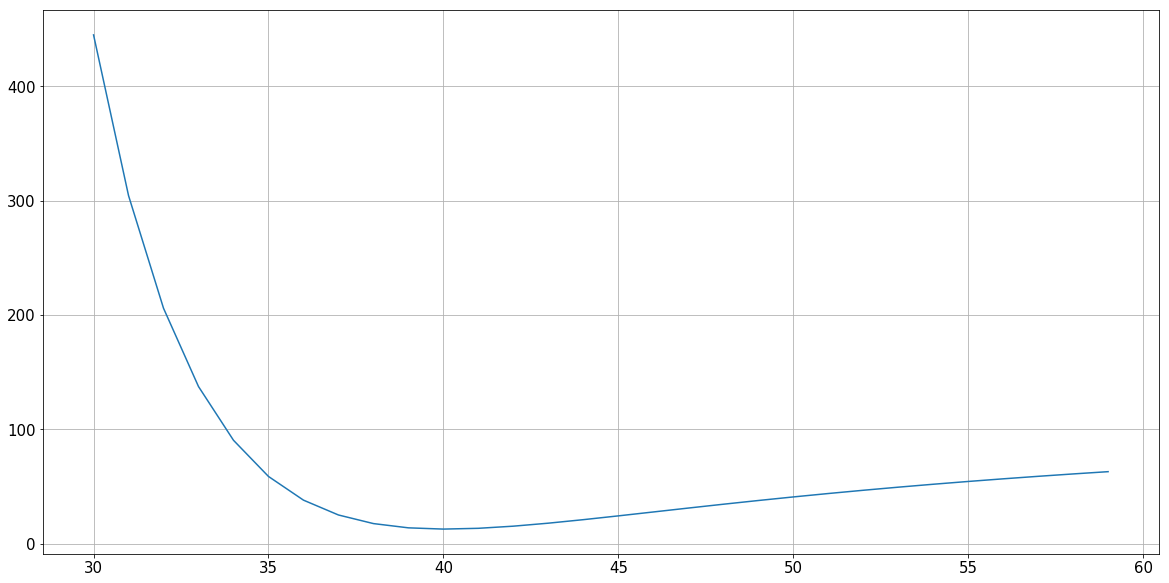

In [82]:
plt.plot(range(30, 60), errs)
grid(True)

In [83]:
result_hdr = joblib.load('results/summary_results_tcnd')
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]
inactive_level = 3.5
active_level = np.mean(full_df.POTENCY.values)
rf_beta = partial(np.interp, xp=bins, fp=result_hdr['rfb'])

In [84]:

def calc_sigma(distance, ia=inactive_level):
    
    fa = frac_active(distance)
    act_sigma = 0.27 + 0.33 * distance
    
    rs = active_level - ia
    
    e_x2 = fa * (rs*rs + act_sigma * act_sigma)
    ex_2 = (fa * rs)**2
    return np.sqrt(e_x2 - ex_2)
    

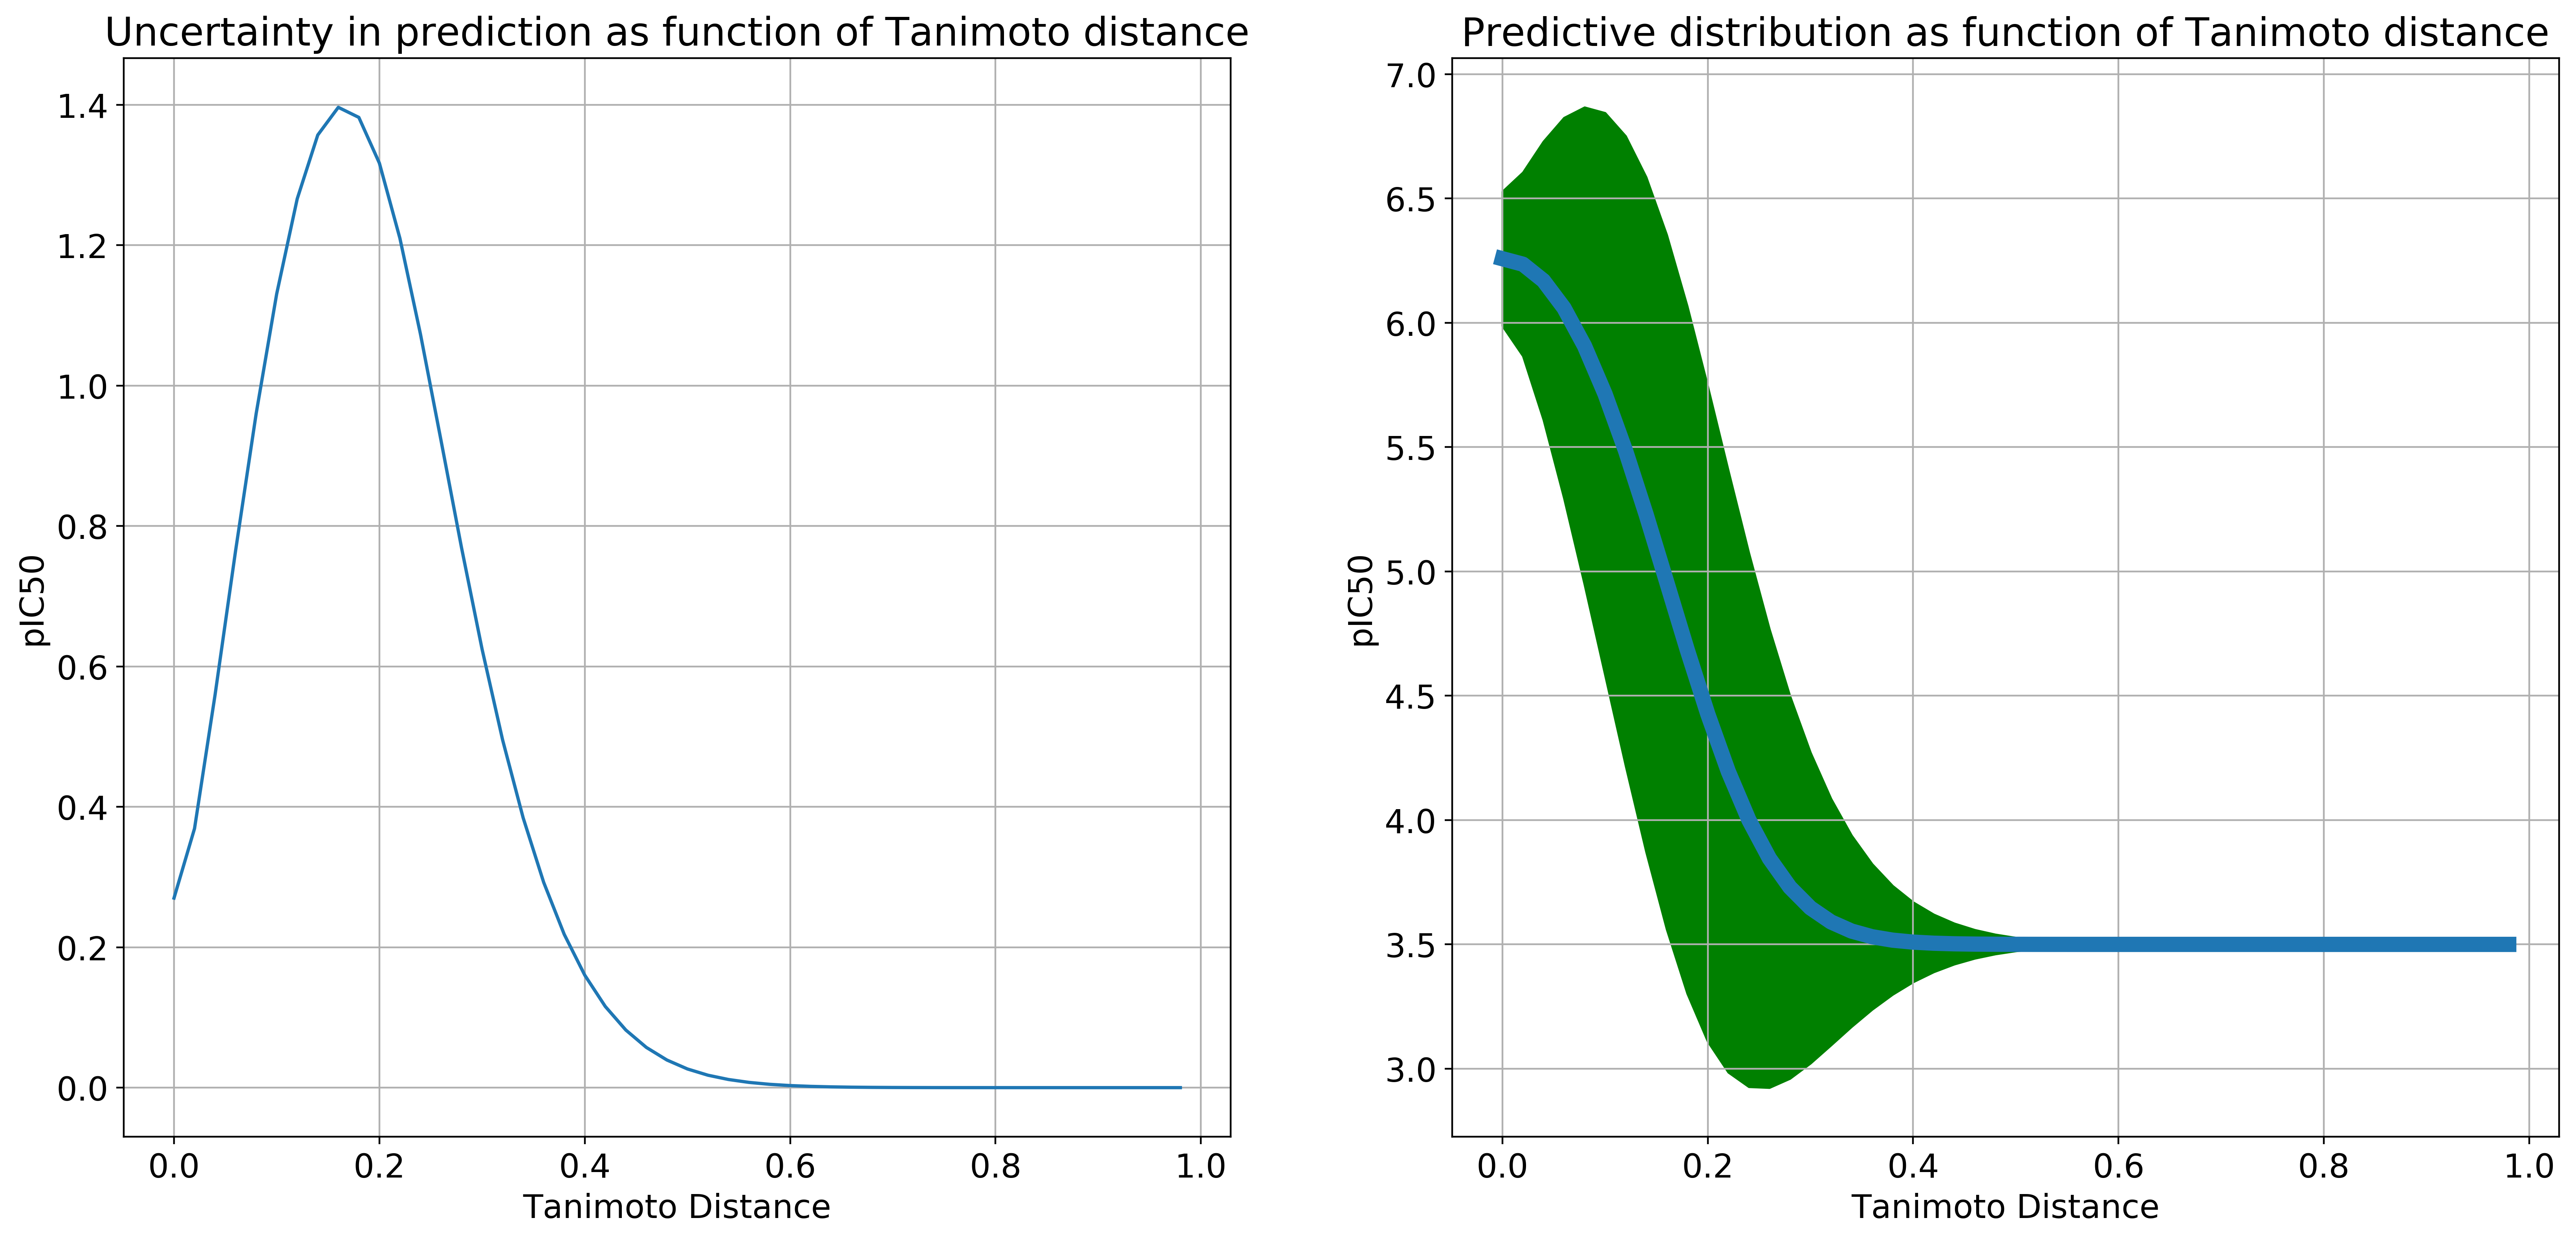

In [85]:
xv = np.arange(50)/50
siga = np.vectorize(calc_sigma)(xv)

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(221)
plt.plot(xv, siga, label='Standard Deviation (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)
plt.title('Uncertainty in prediction as function of Tanimoto distance')
plt.subplot(222)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - siga, yv + siga, color='g')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.title('Predictive distribution as function of Tanimoto distance')
_= plt.ylabel('pIC50')

In [86]:
gd = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6) & (df_tcams_nd['PCT_INHIB_HEPG2'] <= 5)]
# We're going to use the compounds with values < 7.5 for fitting (see Bioinformatics paper)
df_fit = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] <= 7.5)]
# potency random forest model
# set seed so replicable
np.random.seed(42)
pot_model = model_dict['rf']['m'](**model_dict['rf']['kw']).fit(
    np.asarray([fp for fp in df_fit.fps.values]), df_fit.pXC50_3D7.values)


In [87]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists = np.min(cdist(np.asarray([fp for fp in gd.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

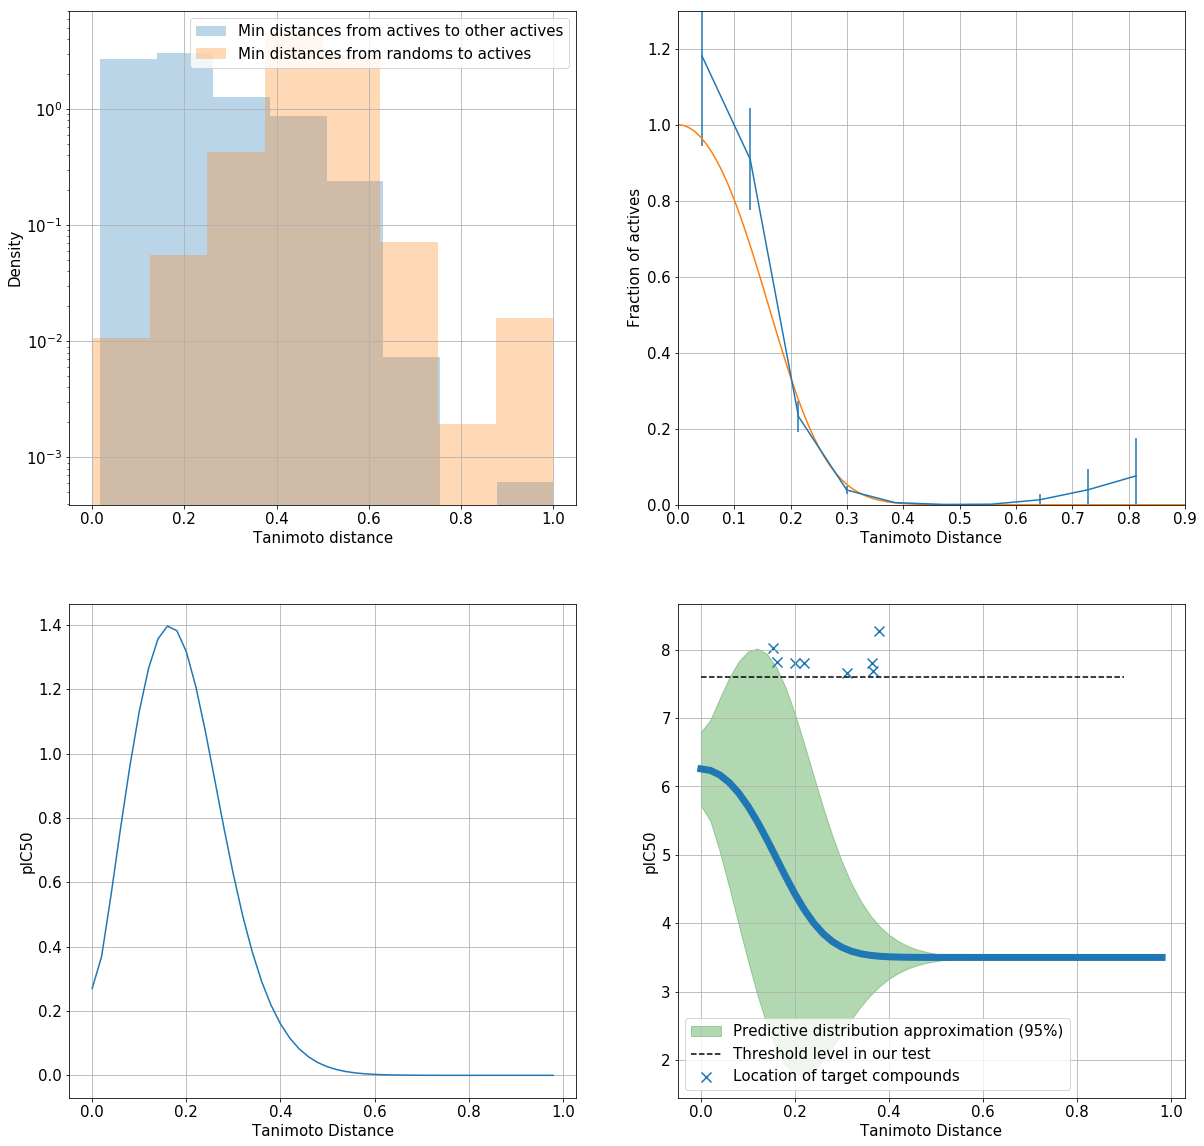

In [88]:
x_axis = 0.5*(mal_hist[1][1:] + mal_hist[1][:-1])
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)

plt.hist(mtc_dists[~np.isnan(mtc_dists)], 
         bins=8, density=True, label=('Min distances from actives to other actives'), alpha=0.3)
plt.hist(all_dists[~np.isnan(all_dists)], 
         bins=8, density=True, label=('Min distances from randoms to actives'), alpha=0.3)
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
plt.grid('True')
plt.legend(loc='best')

plt.subplot(222)

plt.errorbar(mh_axis, y_mean, yerr)
x_axis = np.arange(0, 1, 0.01)
plot(x_axis, 2./(1 + np.exp(40*x_axis**2)))
grid(True)
plt.ylim((0, 1.3))
plt.xlim((0, 0.9))
plt.grid(True)
plt.xlabel('Tanimoto Distance')
_ = plt.ylabel('Fraction of actives')

plt.subplot(223)
plt.plot(xv, siga, label=r'$\sigma$ (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)

plt.subplot(224)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - 2*siga, yv + 2*siga, color='g', alpha=0.3, 
                 label='Predictive distribution approximation (95%)')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.hlines(7.6, 0, 0.9, linestyles='--', label='Threshold level in our test')
#plt.plot(xv, 7.6 + 0 * xv, linewidth=6.0, label='Threshold level in our test', linestyle='--')

plt.scatter(gd_dists, gd.pXC50_3D7.values, marker='x', s=100, label='Location of target compounds')
_= plt.ylabel('pIC50')
plt.legend(loc='best')

savefig('figures/newplot2.png')

In [72]:
cv_result_hdr_128 = joblib.load('cv_result_hdr_128')
cv_result_hdr_1024 = joblib.load('cv_result_hdr_1024')

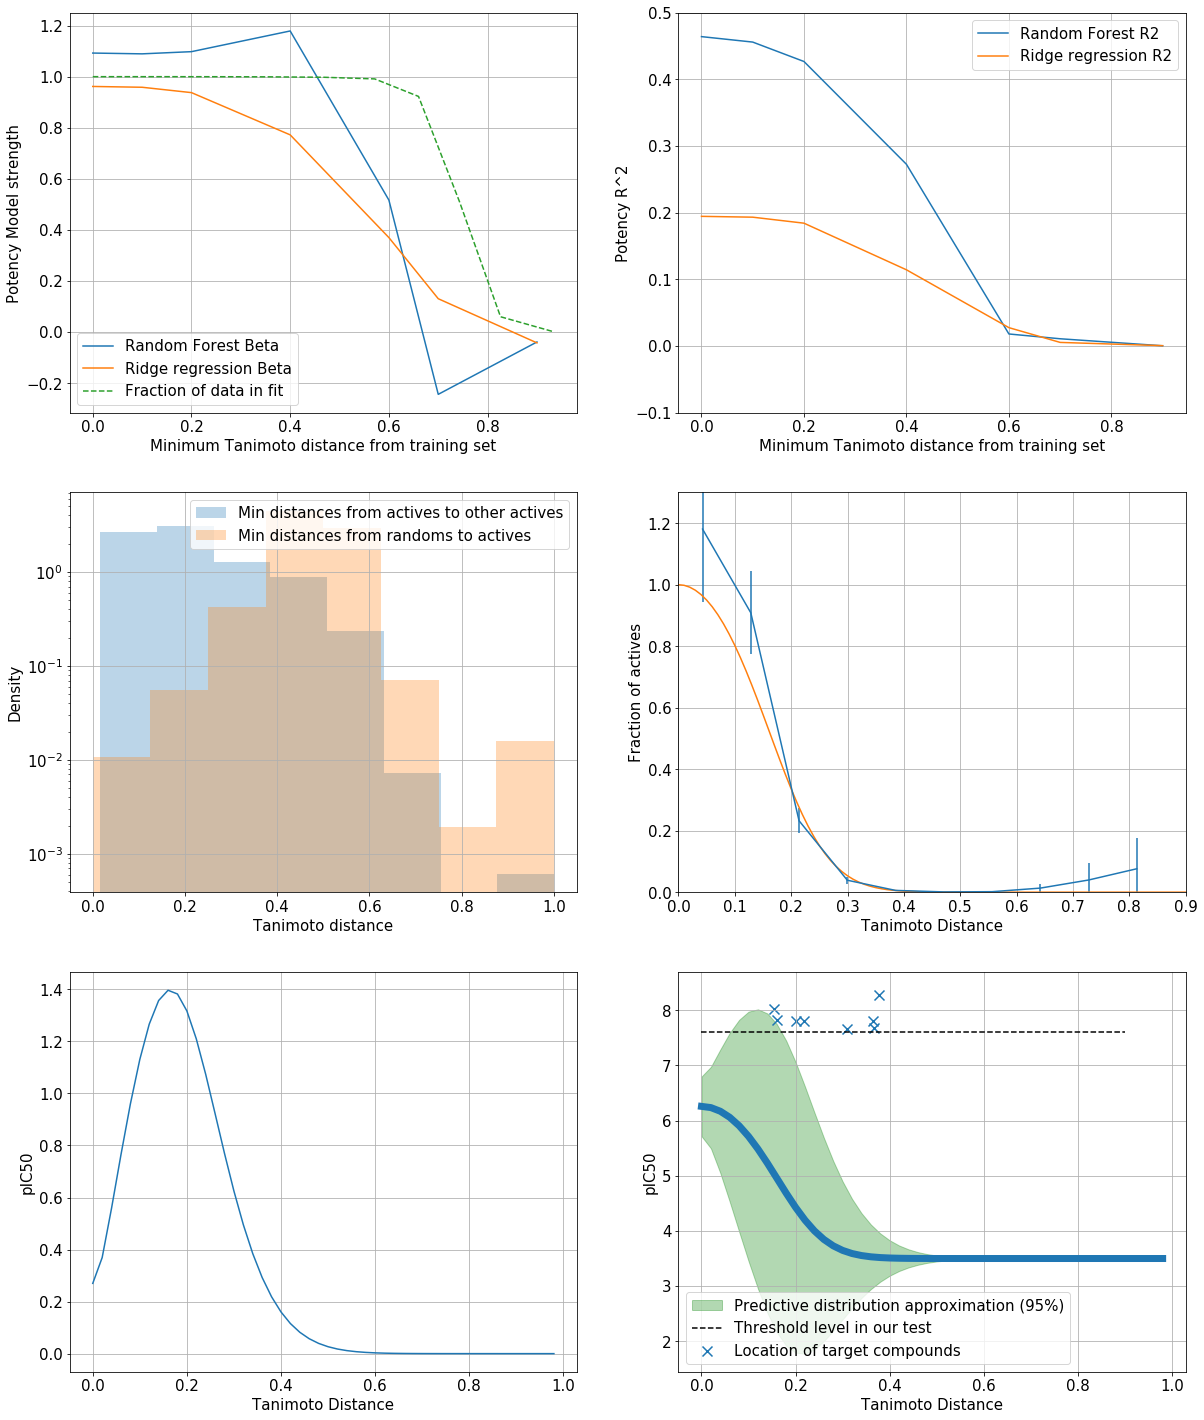

In [95]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 25))
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7,  0.9]
plt.subplot(321)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
#plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Potency Model strength')
plt.plot(ctr_hdr, [x/cd.shape[0] for x in npts_hdr], label='Fraction of data in fit', linestyle='--')
plt.grid(True); plt.legend(loc='best')
#plt.title('Potency model strength')

plt.subplot(322)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
#plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Potency R^2')
plt.ylim((-0.1, 0.5))
_ = plt.grid(True); plt.legend(loc='best')
##_ = plt.title('Potency R2')
x_axis = 0.5*(mal_hist[1][1:] + mal_hist[1][:-1])

plt.subplot(323)

plt.hist(mtc_dists[~np.isnan(mtc_dists)], 
         bins=8, density=True, label=('Min distances from actives to other actives'), alpha=0.3)
plt.hist(all_dists[~np.isnan(all_dists)], 
         bins=8, density=True, label=('Min distances from randoms to actives'), alpha=0.3)
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
plt.grid('True')
plt.legend(loc='best')

plt.subplot(324)

plt.errorbar(mh_axis, y_mean, yerr)
x_axis = np.arange(0, 1, 0.01)
plot(x_axis, 2./(1 + np.exp(40*x_axis**2)))
grid(True)
plt.ylim((0, 1.3))
plt.xlim((0, 0.9))
plt.grid(True)
plt.xlabel('Tanimoto Distance')
_ = plt.ylabel('Fraction of actives')

plt.subplot(325)
plt.plot(xv, siga, label=r'$\sigma$ (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)

plt.subplot(326)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - 2*siga, yv + 2*siga, color='g', alpha=0.3, 
                 label='Predictive distribution approximation (95%)')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.hlines(7.6, 0, 0.9, linestyles='--', label='Threshold level in our test')
#plt.plot(xv, 7.6 + 0 * xv, linewidth=6.0, label='Threshold level in our test', linestyle='--')

plt.scatter(gd_dists, gd.pXC50_3D7.values, marker='x', s=100, label='Location of target compounds')
_= plt.ylabel('pIC50')
plt.legend(loc='best')

savefig('figures/newplot2alt.png')

In [27]:
from malaria import mp_utils, stats

full_models = stats.fit_models(full_df, full_df)

full_models['rfb'] = rf_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

In [28]:
gd_fps = np.asarray([fp for fp in gd.fps.values])
gd_active_potency = pot_model.predict(gd_fps)
gd_frac_active = full_models['frac_act'](gd_dists)
gd_rf_beta = full_models['rfb'](gd_dists)
gd_predicted_potency = gd_frac_active * (gd_rf_beta * gd_active_potency + (1-gd_rf_beta)*active_level) +\
    (1-gd_frac_active)*inactive_level

In [29]:
def run_experiment2(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdpp=gd_predicted_potency, gdd=gd_dists):
    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    uncertainties = np.vectorize(calc_sigma)(distances)
    
    log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:]


In [30]:
def prob_random(n, A=8, T=20):
    x = 1
    num = n - A
    den = n
    for i in range(T):
        x *= num/den
        num -= 1
        den -= 1
    return 1-x

In [31]:
mp1 = pd.read_pickle('test_df')

In [32]:
import scipy

In [33]:
mp_fps = np.asarray([fp for fp in mp1.fps.values])

mp_active_potency = pot_model.predict(mp_fps)
mp_frac_active = full_models['frac_act'](mp1.min_dist.values)
mp_rf_beta = full_models['rfb'](mp1.min_dist.values)
molport_predicted_potency = mp_frac_active * (mp_rf_beta * mp_active_potency + (1-mp_rf_beta)*active_level) +\
    (1-mp_frac_active)*inactive_level
molport_predicted_potency[np.isnan(molport_predicted_potency)] = 0.

In [34]:
def run_experiment(num_choice=100*1000, to_choose=20,  A=8, gdpp=gd_predicted_potency):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    x = sum(np.argsort(potency)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(potency)[-to_choose:]

In [96]:
_ = run_experiment(30*1000)

Probability of success if random 0.00532
Failed


In [97]:
_ = run_experiment(20*1000)

Probability of success if random 0.00797
Succeeded: 2 found


In [35]:
_ = run_experiment()

Probability of success if random 0.00160
Failed


In [36]:
_ = run_experiment2()

Probability of success if random 0.00160
Succeeded: 2 found


In [37]:
_ = run_experiment2(150*1000)

Probability of success if random 0.00107
Succeeded: 1 found


In [38]:
def calc_sigma_active(distance):
    
    #fa = frac_active(distance)
    act_sigma = 0.27 + 0.33 * distance
    
    return act_sigma

In [39]:
def run_experiment3(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdap=gd_active_potency, gdd=gd_dists):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((mp_active_potency[:num_choice], gdap))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    au = np.vectorize(calc_sigma_active)(distances)
    
    #log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    log_lik = np.log(frac_active(distances)) + scipy.stats.norm.logcdf((potency-target)/au)
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:], log_lik[np.argsort(log_lik)[-to_choose:]]


In [40]:
_ = run_experiment3()

Probability of success if random 0.00160
Succeeded: 3 found


In [41]:
_ = run_experiment3(200*1000)

Probability of success if random 0.00080
Succeeded: 2 found


In [42]:
_ = run_experiment3(300*1000)

Probability of success if random 0.00053
Succeeded: 2 found


In [43]:
_ = run_experiment3(480*1000)

Probability of success if random 0.00033
Succeeded: 2 found


In [44]:
faa = frac_active(np.arange(0, 1, 0.01))
act_sigmas = calc_sigma_active(np.arange(0, 1, 0.01))
one_pct_line = np.zeros_like(faa)
one_pct_line[faa <= 0.01] = inactive_level
one_pct_line[faa > 0.01] = (active_level + act_sigmas * scipy.stats.norm.ppf(faa).clip(-4,4))[faa > 0.01]


In [45]:
def get_contour_ll_line(target=7.6, start_point=6.5):
    """
    Gets the log-likelihood as a function of distance (log probability of a compound at distance
    d from the starting point having activity >= target).
    """
    d = np.arange(0, 1, 0.01)
    betas = full_models['rfb'](d)
    active_means = betas * start_point + (1 - betas) * active_level
    return np.log(frac_active(d)) +\
        scipy.stats.norm.logcdf((active_means-target)/np.vectorize(calc_sigma_active)(d))

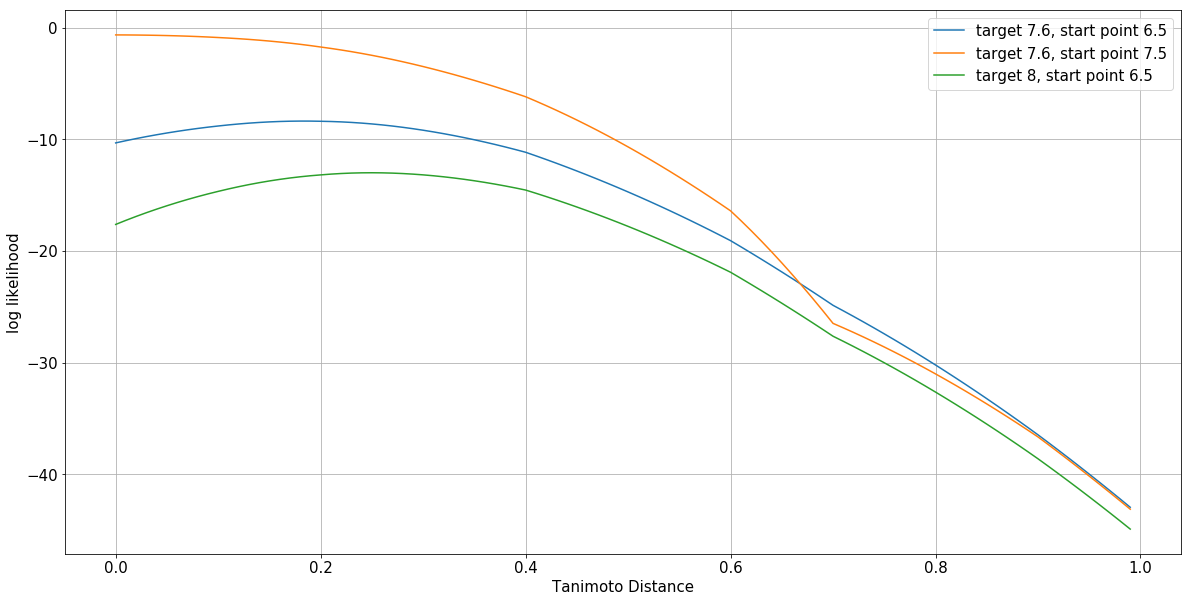

In [46]:
d = np.arange(0, 1, 0.01)
plot(d, get_contour_ll_line(), label='target 7.6, start point 6.5')
plot(d, get_contour_ll_line(start_point=7.5), label='target 7.6, start point 7.5')
plot(d, get_contour_ll_line(target=8), label='target 8, start point 6.5')
ylabel('log likelihood')
xlabel('Tanimoto Distance')
legend(loc='best')
savefig("figures/ll_contour_lines.png")
grid(True)

### Using all compounds with activity > 7.6

In [47]:
gd2 = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6)]

In [48]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists2 = np.min(cdist(np.asarray([fp for fp in gd2.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

In [49]:
gd_fps2 = np.asarray([fp for fp in gd2.fps.values])
gd_active_potency2 = pot_model.predict(gd_fps2)
gd_frac_active2 = full_models['frac_act'](gd_dists2)
gd_rf_beta2 = full_models['rfb'](gd_dists2)
gd_predicted_potency2 = gd_frac_active2 * (gd_rf_beta2 * gd_active_potency2 + (1-gd_rf_beta2)*active_level) +\
    (1-gd_frac_active2)*inactive_level

In [50]:
# Dumb method
_ = run_experiment(num_choice=480*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.00834
Failed


In [104]:
_ = run_experiment(num_choice=20*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.18134
Succeeded: 8 found


In [105]:
_ = run_experiment(num_choice=30*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.12506
Failed


In [51]:
# Hacky Ollie method
_ = run_experiment2(num_choice=480*1000, A=201, gdd=gd_dists2, gdpp=gd_predicted_potency2)

Probability of success if random 0.00834
Succeeded: 6 found


In [52]:
# Correct James method
_ = run_experiment3(num_choice=480*1000, A=201, gdd=gd_dists2, gdap=gd_active_potency2)

Probability of success if random 0.00834
Succeeded: 18 found
